In [101]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, RandomAffine, Compose
import matplotlib.pyplot as plt
from random import randint

In [102]:
# Download training data from open datasets.
og_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

T = RandomAffine(degrees=90, translate=(0.2,0.2), scale=(0.4, 1.2))

random_training = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([
        ToTensor(),
        RandomAffine(degrees=45, translate=(0.3,0.3), scale=(0.8, 1.2))
    ]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

training_data = ConcatDataset([og_training_data, random_training])

# Download test data from open datasets.
og_test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

random_testing = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([
        ToTensor(),
        RandomAffine(degrees=45, translate=(0.3,0.3), scale=(0.8, 1.2))
    ]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

test_data = ConcatDataset([og_test_data, random_testing])


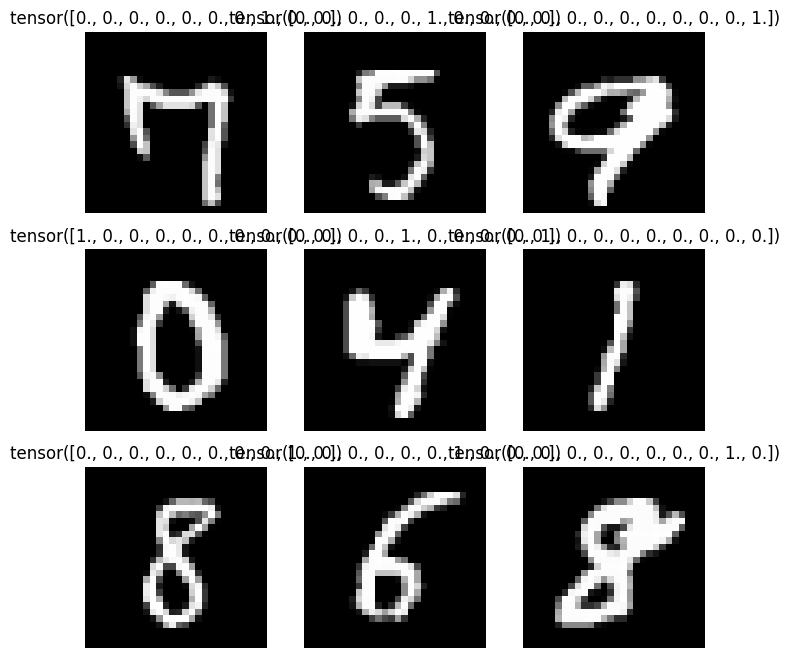

In [51]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = randint(0,len(training_data))
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [52]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [53]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [54]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [55]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [68]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()


    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [72]:
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.065927  [    0/60000]
loss: 0.065158  [ 6400/60000]
loss: 0.068636  [12800/60000]
loss: 0.064697  [19200/60000]
loss: 0.065893  [25600/60000]
loss: 0.065943  [32000/60000]
loss: 0.065550  [38400/60000]
loss: 0.066682  [44800/60000]
loss: 0.065996  [51200/60000]
loss: 0.066075  [57600/60000]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.065247 

Epoch 2
-------------------------------
loss: 0.064966  [    0/60000]
loss: 0.064178  [ 6400/60000]
loss: 0.067675  [12800/60000]
loss: 0.063719  [19200/60000]
loss: 0.064970  [25600/60000]
loss: 0.065026  [32000/60000]
loss: 0.064481  [38400/60000]
loss: 0.065810  [44800/60000]
loss: 0.065123  [51200/60000]
loss: 0.065095  [57600/60000]
Test Error: 
 Accuracy: 72.7%, Avg loss: 0.064302 

Epoch 3
-------------------------------
loss: 0.064024  [    0/60000]
loss: 0.063214  [ 6400/60000]
loss: 0.066736  [12800/60000]
loss: 0.062780  [19200/60000]
loss: 0.064084  [25600/60000]
loss: 0.064135  [32000/600

In [73]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [103]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

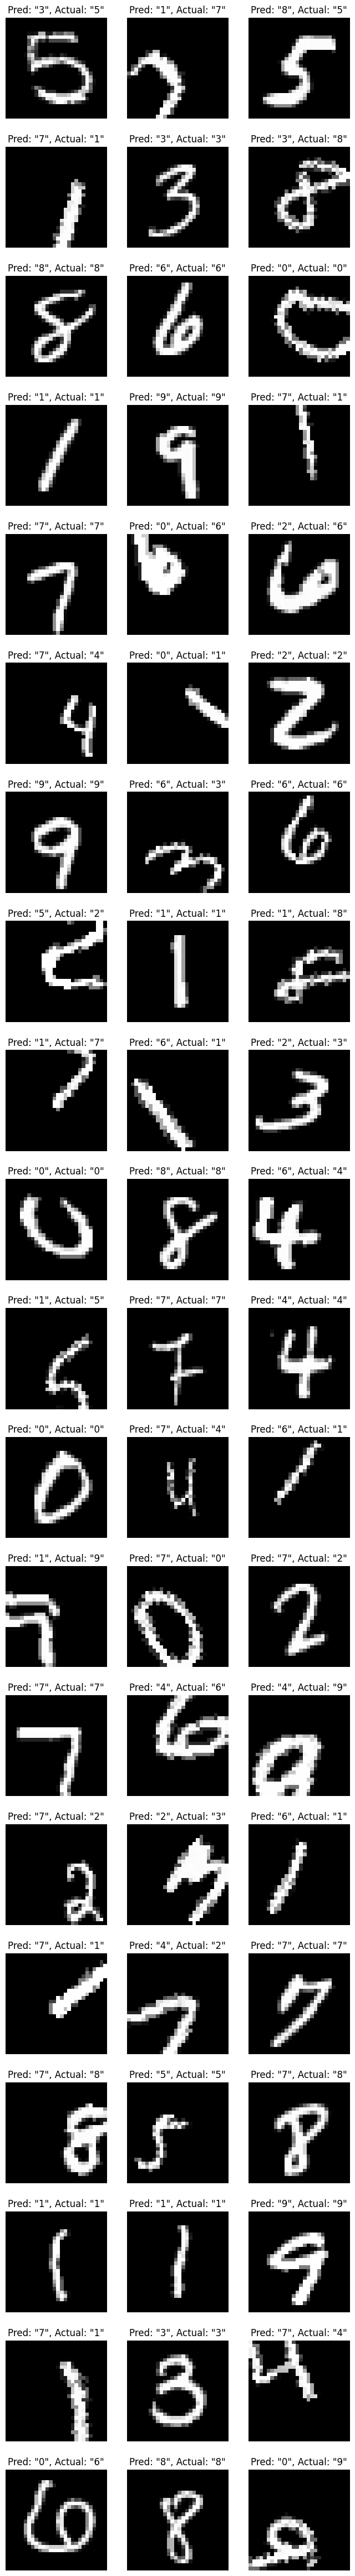

In [104]:
model.eval()

cols, rows = 3, 20
figure = plt.figure(figsize=(cols*2+2, rows*3))
for i in range(1, cols * rows + 1):
    sample_idx = randint(0,len(test_data))
    img, label = test_data[sample_idx]
    with torch.no_grad():
        pred = model(img)
        predicted, actual = pred.argmax(1).item(), label.argmax(0)
    figure.add_subplot(rows, cols, i)
    plt.title(f'Pred: "{predicted}", Actual: "{actual}"')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()